# Understanding Linear Layer 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


<img src='F-24-6.max-800x600.png'>

* How to represent coordinates of A and B?
* We can using linear transformation to change the representation.

In [2]:
def initializer(shape, dtype=None):
    return np.array([[1], [2]], dtype=np.float32)

A = np.array([[2, 1], [2, 3], [0, 3], [0, 1]])
B = np.array([[4, 0], [4, 2], [0, 3], [0, 1]])

linear = tf.keras.layers.Dense(1, kernel_initializer=initializer)
# linear = tf.keras.layers.Dense(2)
WA = linear(A)
WB = linear(B)
print('WA: ')
print(WA.numpy())
print('WB: ')
print(WB.numpy())

WA: 
[[4.]
 [8.]
 [6.]
 [2.]]
WB: 
[[4.]
 [8.]
 [6.]
 [2.]]


* Seems like the representation of A and B are same.
* How about increase the parameters in linear transformation?

In [3]:
def initializer(shape, dtype=None):
    return np.array([[1, 2, 3], [2, 3, 4]], dtype=np.float32)

linear2 = tf.keras.layers.Dense(3, kernel_initializer=initializer)
# linear = tf.keras.layers.Dense(2)
WA = linear2(A)
WB = linear2(B)
print('WA: ')
print(WA.numpy())
print('WB: ')
print(WB.numpy())

WA: 
[[ 4.  7. 10.]
 [ 8. 13. 18.]
 [ 6.  9. 12.]
 [ 2.  3.  4.]]
WB: 
[[ 4.  8. 12.]
 [ 8. 14. 20.]
 [ 6.  9. 12.]
 [ 2.  3.  4.]]


# Convolutional Neural Network

## Manual Kernel

https://en.wikipedia.org/wiki/Kernel_(image_processing)

Width = 640, Height = 640


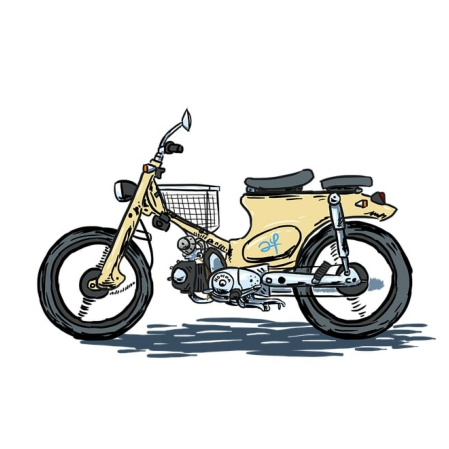

In [4]:
from PIL import Image

img = Image.open("./bike.jpg")
print(f'Width = {img.size[0]}, Height = {img.size[1]}')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img)
ax.axis('off')
plt.show()

$$\text{Ridge Kernel} = \begin{bmatrix}-1 & -1 & -1 \\ -1 & 4 & -1 \\ -1 & -1 & -1\end{bmatrix}$$

Size of Image: (1, 640, 640, 3)
Size of Kernel: (3, 3, 3, 1)
Size of Output: (1, 638, 638, 1)


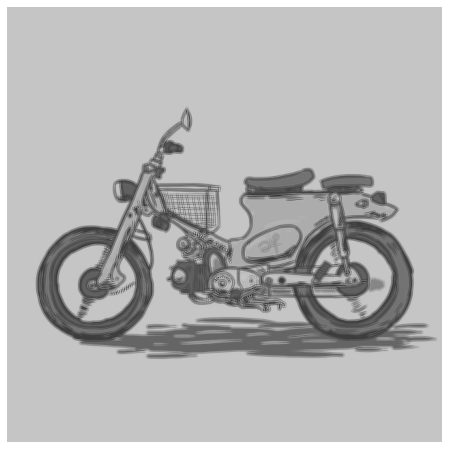

In [5]:
# Ridge Detection: (K_H, K_W, C_in, C_out) = (3, 3, 3, 1)
def ridge_kernel_initializer():
    kernel = np.array([
        [-1, -1, -1], 
        [-1,  4, -1], 
        [-1, -1, -1]
    ], dtype=np.float32)
    kernel = np.repeat(np.expand_dims(kernel, 2), 3, axis=-1)[...,None]
    return kernel

inputs = np.array(img)[None,].astype(np.float32)
print(f'Size of Image: {inputs.shape}')
kernel = ridge_kernel_initializer()
print(f'Size of Kernel: {kernel.shape}')
outputs = tf.nn.conv2d(inputs, kernel, strides=1, padding='VALID')
print(f'Size of Output: {outputs.shape}')

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.squeeze(outputs.numpy()), cmap='binary')
ax.axis('off')
plt.show()

**Translation Equivariance**

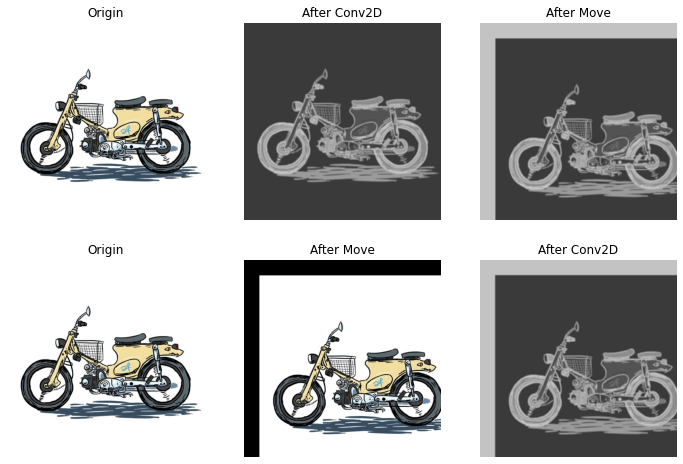

In [6]:
def move_image(image, ox, oy):
    # https://stackoverflow.com/questions/27087139/shifting-an-image-in-numpy
    non = lambda s: s if s < 0 else None
    mom = lambda s: max(0, s)

    shifted_image = np.zeros_like(image)
    shifted_image[mom(oy):non(oy), mom(ox):non(ox)] = image[mom(-oy):non(-oy), mom(-ox):non(-ox)]
    return shifted_image

def draw_translation_equivariance(axs, imgs_type, titles_type):
    for i, (ax, image, title) in enumerate(zip(axs, imgs_type, titles_type)):
        if i == 0:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(title)

ox = 50
oy = 50
moved_img = move_image(np.array(img), ox, oy)
moved_inputs = moved_img[None,].astype(np.float32)
moved_outputs = tf.nn.conv2d(moved_inputs, kernel, strides=1, padding='VALID')
outputs_moved = move_image(np.squeeze(outputs), ox, oy)

imgs_type1 = [np.array(img), np.squeeze(outputs), outputs_moved]
titles_type1 = ['Origin', 'After Conv2D', 'After Move']
imgs_type2 = [np.array(img), moved_img, np.squeeze(moved_outputs)]
titles_type2 = ['Origin', 'After Move', 'After Conv2D']

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
ax1, ax2 = axes[0, :], axes[1, :]
draw_translation_equivariance(axs=ax1, imgs_type=imgs_type1, titles_type=titles_type1)
draw_translation_equivariance(axs=ax2, imgs_type=imgs_type2, titles_type=titles_type2)
plt.show()

* [`tf.keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

$$\dfrac{640 + 2\times 0 - 5}{5} + 1 = 128 $$

Size of Conv2D outputs: (1, 128, 128, 4)


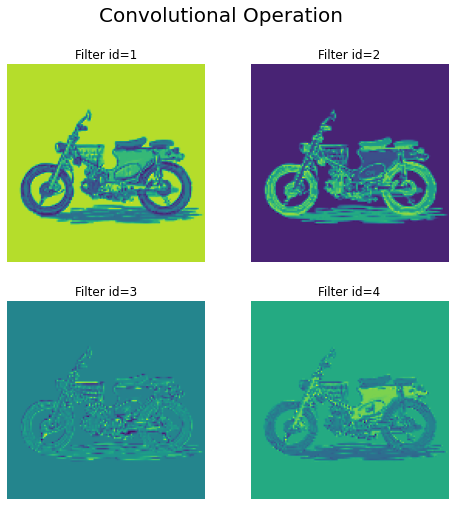

Number of parameters: 304


In [7]:
seed = 42
tf.random.set_seed(seed)
conv_layer = tf.keras.layers.Conv2D(
    filters=4,
    kernel_size=(5, 5),
    strides=5,
    use_bias=True
)
conv_outputs = conv_layer(inputs)
print(f'Size of Conv2D outputs: {conv_outputs.shape}')

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, (o, ax) in enumerate(zip(tf.transpose(conv_outputs[0], perm=[2, 0, 1]), axes.flatten())):
    ax.imshow(o.numpy())
    ax.axis('off')
    ax.set_title(f'Filter id={i+1}')
fig.suptitle('Convolutional Operation', fontsize=20)
plt.show()
print(f'Number of parameters: {conv_layer.count_params()}')

* `valid` padding / `same` padding: https://www.tensorflow.org/api_docs/python/tf/nn#notes_on_padding_2

$$x_{out} = \dfrac{x_{in} + 2 \times p - k}{s} + 1$$

In [8]:
tf.random.set_seed(seed)
inputs = tf.random.normal((1, 640, 640, 3))
filters = 4
kernel_size = 5
strides = 5
valid_conv_layer = tf.keras.layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    strides=strides,
    padding='valid'
)
valid_conv_outputs = valid_conv_layer(inputs)
print(f'Size of Valid Padding Outputs: {valid_conv_outputs.shape}')

same_conv_layer = tf.keras.layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    strides=strides,
    padding='same'
)
same_conv_outputs = same_conv_layer(inputs)

print(f'Size of Same Padding Outputs: {same_conv_outputs.shape}')

Size of Valid Padding Outputs: (1, 128, 128, 4)
Size of Same Padding Outputs: (1, 128, 128, 4)


In [9]:
x_in = 640
k = 5
s = 5
# valid
valid_x_out = np.ceil((x_in - k + 1) / s)
print(f'Valid Padding outputs = {valid_x_out}')
# same
same_x_out = np.ceil(x_in / s)
print(f'Same Padding outputs = {same_x_out}')
if (x_in % s == 0):
    pad = np.max(k - s, 0)
else:
    pad = np.max(k - (x_in % s), 0)
print(f'Padding Size: {pad}')

Valid Padding outputs = 128.0
Same Padding outputs = 128.0
Padding Size: 0


* if stride equals to 1, then the output image size will be the same as input image size.

In [10]:
x_in = 32
k = 3
s = 1
# valid
valid_x_out = np.ceil((x_in - k + 1) / s)
print(f'Valid Padding outputs = {valid_x_out}')
# same
same_x_out = np.ceil(x_in / s)
print(f'Same Padding outputs = {same_x_out}')
if (x_in % s == 0):
    pad = np.max(k - s, 0)
else:
    pad = np.max(k - (x_in % s), 0)
print(f'Padding Size: {pad}')

Valid Padding outputs = 30.0
Same Padding outputs = 32.0
Padding Size: 2


### Activation Maps

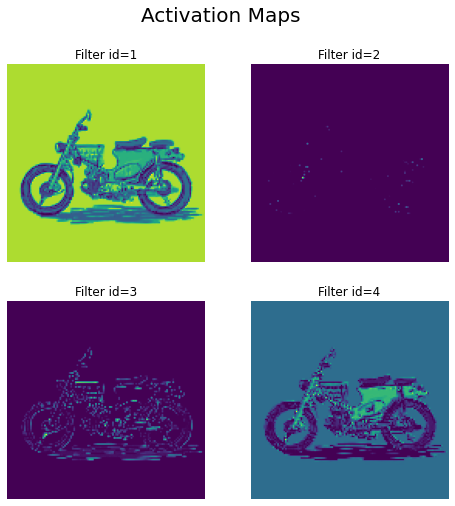

In [11]:
tf.random.set_seed(seed)
# conv_layer = tf.keras.layers.Conv2D(
#     filters=4,
#     kernel_size=(5, 5),
#     strides=5,
#     use_bias=True,
#     activation='relu'
# )
act_outputs = tf.keras.layers.Activation('relu')(conv_outputs)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, (o, ax) in enumerate(zip(tf.transpose(act_outputs[0], perm=[2, 0, 1]), axes.flatten())):
    ax.imshow(o.numpy())
    ax.axis('off')
    ax.set_title(f'Filter id={i+1}')
fig.suptitle('Activation Maps', fontsize=20)
plt.show()

### Maxpooling Layer

* [`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

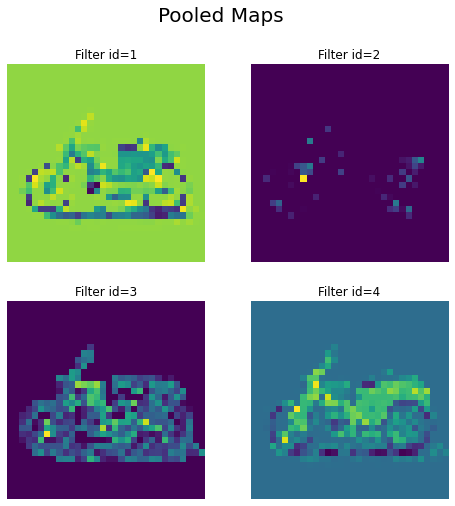

In [12]:
maxpool_layer = tf.keras.layers.MaxPool2D(pool_size=(4, 4))
pooled_outputs = maxpool_layer(act_outputs)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, (o, ax) in enumerate(zip(tf.transpose(pooled_outputs[0], perm=[2, 0, 1]), axes.flatten())):
    ax.imshow(o.numpy())
    ax.axis('off')
    ax.set_title(f'Filter id={i+1}')
fig.suptitle('Pooled Maps', fontsize=20)
plt.show()

---

# Training CIFAR10 data

[Cifar 10](https://www.tensorflow.org/datasets/catalog/cifar10) is a classification problem with 10 classes, which has (32x32) size of RGB image.

<img src="http://drive.google.com/uc?export=view&id=1hUADKewEX64tB7vxVeYy2eKAJ4u4sVfb" width="480px" height="480px" >

## Loading Data & Preprocessing Pipeline

In [13]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import absl.logging
from PIL import Image
absl.logging.set_verbosity(absl.logging.ERROR)

print(f'TF: {tf.__version__}, TFDS: {tfds.__version__}')

TF: 2.9.1, TFDS: 4.6.0


In [14]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='cifar10',
    split=['train[:80%]', 'train[80%:]', 'test'],
    data_dir='./data/cifar10/',
    download=True,
    with_info=True,
    as_supervised=True,
)

In [15]:
print(f'Train: {len(raw_train)}, Valid: {len(raw_validation)}, Test: {len(raw_test)}')
print(metadata.features)
print()
print('Labels')
get_label_name = metadata.features['label'].int2str
for i in range(metadata.features['label'].num_classes):
    print(f'{i}: {get_label_name(i)}')

Train: 40000, Valid: 10000, Test: 10000
FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

Labels
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


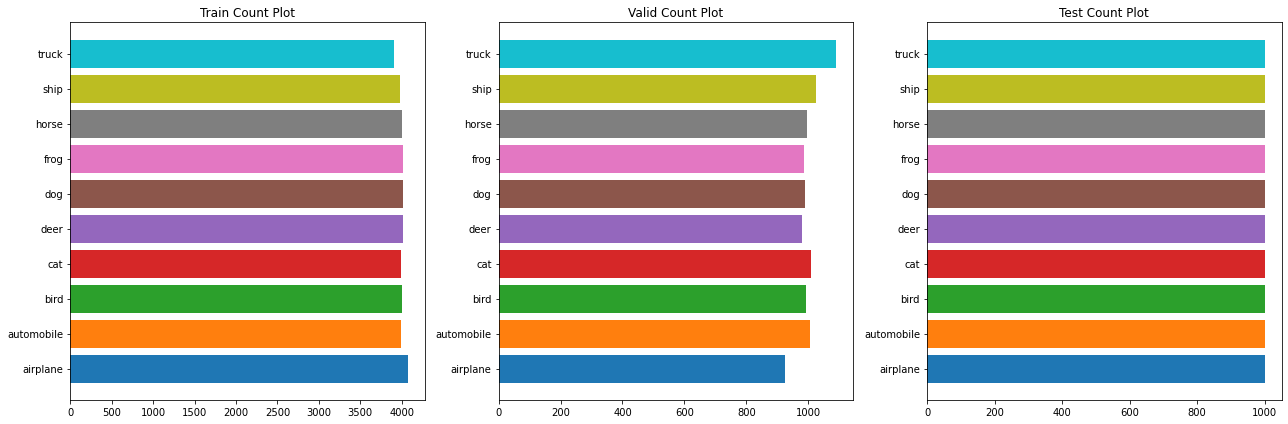

In [16]:
# check the class imbalance
from matplotlib.cm import tab10

def plot_barplot(ax, labels, title):
    uniques, cnts = np.unique(labels, return_counts=True)
    labels = [get_label_name(u) for u in uniques]
    colors = [tab10.colors[u] for u in uniques]
    ax.barh(labels, cnts, color=colors)
    ax.set_title(f'{title} Count Plot')

train_labels = np.array(list(map(lambda x: x[1].numpy(), raw_train)))
valid_labels = np.array(list(map(lambda x: x[1].numpy(), raw_validation)))
test_labels = np.array(list(map(lambda x: x[1].numpy(), raw_test)))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, labels, title in zip(axes, [train_labels, valid_labels, test_labels], ['Train', 'Valid', 'Test']):
    plot_barplot(ax, labels, title)
plt.tight_layout()
plt.show()

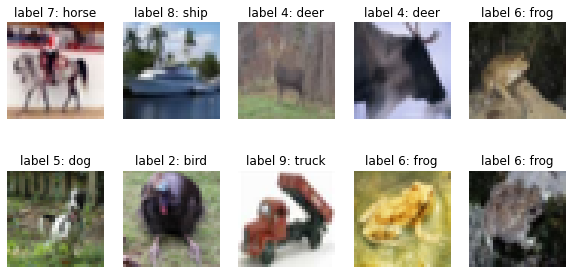

In [17]:
plt.figure(figsize=(10, 5))

for idx, (image, label) in enumerate(raw_train.take(10)):  # take 10 data
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

* [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image)

In [18]:
def formatting(image, label):
    image = tf.cast(image, tf.float32)  # cast to tf.float32
    image = tf.image.per_image_standardization(image)
    return image, label

train = raw_train.map(formatting)
validation = raw_validation.map(formatting)
test = raw_test.map(formatting)

# setting batches & shuffle
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

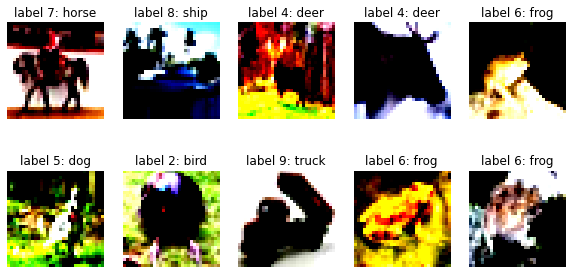

In [19]:
plt.figure(figsize=(10, 5))

for idx, (image, label) in enumerate(train.take(10)):  # take 10 data
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')
plt.show()

---

## CNN Model

### Design Network

* Input Size = (B, 32, 32, 3)
* Output Size = (B, 10)
* Loss Function: Cross Entropy Loss
* Optimizer: Adam with 0.001 initialize learning rate

### CNN Model

* Use `tf.keras.models.Sequential`
* Convolutional Layer: 

    > Conv1
    > 
    > 1. Conv2D: output channel = 16, kernel size = 3, padding = same, activation = relu
    > 2. MaxPooling2D: pool size = 2
    > 
    > Conv2
    > 1. Conv2D: output channel = 32, kernel size = 3, padding = same, activation = relu
    > 2. MaxPooling2D(`nn.MaxPool2d`): pool size = 2
    > 
    > Conv3
    > 1. Conv2D: output channel = 64, kernel size = 3, padding = same, activation = relu
    > 2. MaxPooling2D(`nn.MaxPool2d`): pool size = 2
    
* Fully Connected Layer:

    > 1. Flatten: flatten the size
    > 2. Dense: units = 512, activation = relu
    > 3. Dense: units = 10, activation = none

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=10)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0

* [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [21]:
from pathlib import Path
checkpoint_dir = Path('./checkpoints/cnn/')

model_name = 'model1'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=False
)

In [22]:
# model compile
learning_rate = 0.001
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [23]:
# fit
EPOCHS = 10
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Epoch 1/10
622/625 [============================>.] - ETA: 0s - loss: 1.3763 - accuracy: 0.5052INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


625/625 [==============================] - 7s 10ms/step - loss: 1.3752 - accuracy: 0.5056 - val_loss: 1.1158 - val_accuracy: 0.6034
Epoch 2/10
619/625 [============================>.] - ETA: 0s - loss: 0.9855 - accuracy: 0.6538INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


625/625 [==============================] - 6s 9ms/step - loss: 0.9850 - accuracy: 0.6539 - val_loss: 0.9280 - val_accuracy: 0.6717
Epoch 3/10
624/625 [============================>.] - ETA: 0s - loss: 0.7990 - accuracy: 0.7223INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


625/625 [==============================] - 6s 9ms/step - loss: 0.7990 - accuracy: 0.7223 - val_loss: 0.8670 - val_accuracy: 0.7019
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.6582 - accuracy: 0.7698 - val_loss: 0.9009 - val_accuracy: 0.7003
Epoch 5/10
623/625 [============================>.] - ETA: 0s - loss: 0.5316 - accuracy: 0.8133INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


625/625 [==============================] - 6s 9ms/step - loss: 0.5315 - accuracy: 0.8134 - val_loss: 0.8742 - val_accuracy: 0.7183
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4169 - accuracy: 0.8528 - val_loss: 0.9656 - val_accuracy: 0.7166
Epoch 7/10
625/625 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8950INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model1\assets


625/625 [==============================] - 6s 9ms/step - loss: 0.3024 - accuracy: 0.8950 - val_loss: 1.0028 - val_accuracy: 0.7260
Epoch 8/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2242 - accuracy: 0.9209 - val_loss: 1.1746 - val_accuracy: 0.7151
Epoch 9/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1664 - accuracy: 0.9423 - val_loss: 1.3173 - val_accuracy: 0.7180
Epoch 10/10
625/625 [==============================] - 5s 8ms/step - loss: 0.1275 - accuracy: 0.9545 - val_loss: 1.3364 - val_accuracy: 0.7250


In [24]:
new_model = tf.keras.models.load_model(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

10/10 [==============================] - 0s 4ms/step - loss: 0.9708 - accuracy: 0.7422
Test Loss: 0.9708, Accuracy: 0.7422


In [25]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.plot(epochs_range, acc, label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    ax2.plot(epochs_range, loss, label='Training Loss')
    ax2.plot(epochs_range, val_loss, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    plt.tight_layout()
    plt.legend()
    plt.show()

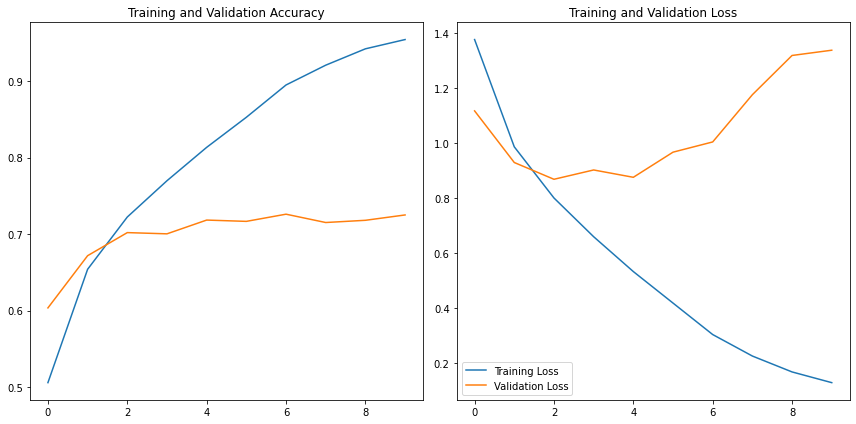

In [26]:
plot_results(history)

### Improve Model with following methods

* Add one of BatchNorm Layers
* Add more layers(paramaters)
* Add regularizer: Dropout, weight decay
* Change Optimizer

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=10)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)      

In [28]:
model_name = 'model2'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=False
)

In [29]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Epoch 1/10
621/625 [============================>.] - ETA: 0s - loss: 1.3466 - accuracy: 0.5258INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


625/625 [==============================] - 7s 12ms/step - loss: 1.3445 - accuracy: 0.5266 - val_loss: 1.0366 - val_accuracy: 0.6332
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.9577 - accuracy: 0.6622INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.9577 - accuracy: 0.6622 - val_loss: 0.9853 - val_accuracy: 0.6519
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.7164INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.8041 - accuracy: 0.7164 - val_loss: 0.8469 - val_accuracy: 0.7057
Epoch 4/10
625/625 [==============================] - 7s 10ms/step - loss: 0.7020 - accuracy: 0.7538 - val_loss: 0.8791 - val_accuracy: 0.7013
Epoch 5/10
624/625 [============================>.] - ETA: 0s - loss: 0.6215 - accuracy: 0.7818INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.6214 - accuracy: 0.7818 - val_loss: 0.8752 - val_accuracy: 0.7121
Epoch 6/10
622/625 [============================>.] - ETA: 0s - loss: 0.5469 - accuracy: 0.8080INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


625/625 [==============================] - 7s 12ms/step - loss: 0.5473 - accuracy: 0.8081 - val_loss: 0.8027 - val_accuracy: 0.7335
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4876 - accuracy: 0.8282 - val_loss: 0.8914 - val_accuracy: 0.7223
Epoch 8/10
623/625 [============================>.] - ETA: 0s - loss: 0.4298 - accuracy: 0.8499INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model2\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.4296 - accuracy: 0.8500 - val_loss: 0.8272 - val_accuracy: 0.7400
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3808 - accuracy: 0.8673 - val_loss: 0.9492 - val_accuracy: 0.7283
Epoch 10/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3256 - accuracy: 0.8855 - val_loss: 0.9124 - val_accuracy: 0.7360


10/10 [==============================] - 0s 4ms/step - loss: 0.8016 - accuracy: 0.7563
Test Loss: 0.8016, Accuracy: 0.7563


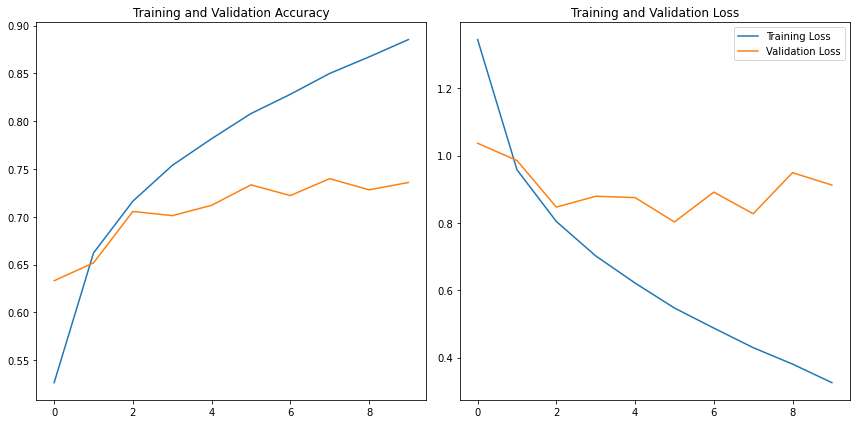

In [30]:
new_model = tf.keras.models.load_model(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

plot_results(history)

---

# Data Augmentation

* https://www.tensorflow.org/api_docs/python/tf/image
* https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko

In [31]:
def visualize(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax1, ax2 = axes
    ax1.set_title('Original image')
    ax1.imshow(original)

    ax2.set_title('Augmented image')
    ax2.imshow(augmented)
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

image = np.array(Image.open("./bike.jpg"))

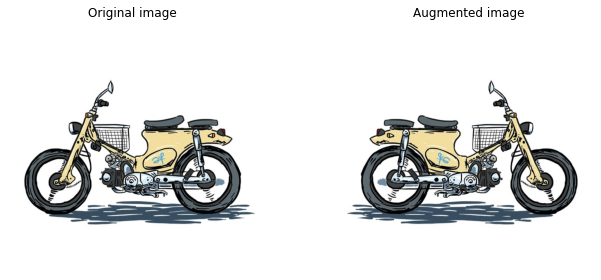

In [32]:
# Flip
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

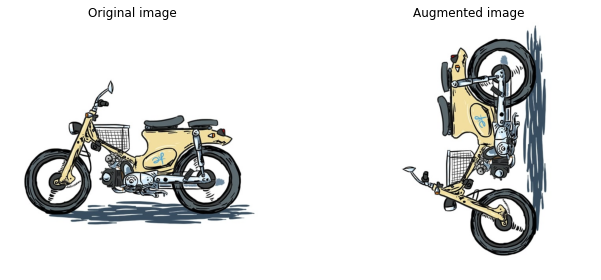

In [33]:
# Rotate
rotated = tf.image.rot90(image)
visualize(image, rotated)

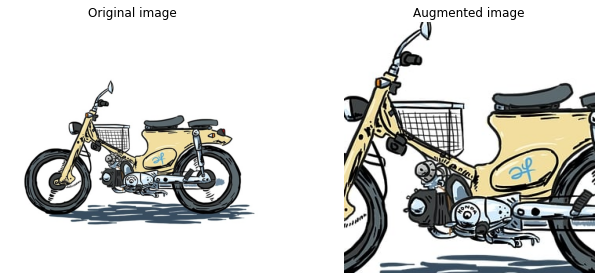

In [34]:
# Crop
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

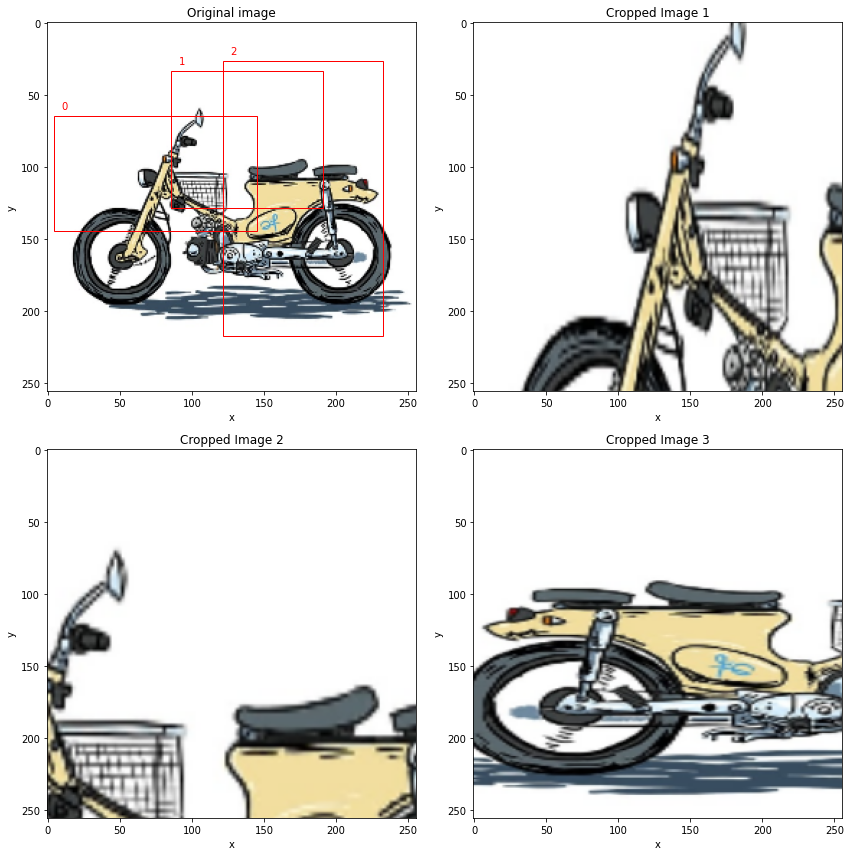

In [35]:
from matplotlib.patches import Rectangle

def get_xywh(box, size):
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html
    if not isinstance(box, np.ndarray):
        box = box.numpy()
    y1, x1, y2, x2,  = (box * (size-1))
    x = min(x1, x2)
    y = min(y1, y2)
    return (x, y), abs(x1-x2), abs(y1-y2)

tf.random.set_seed(75)
# crop by boxes
NUM_BOXES = 3
CROP_SIZE = (256, 256)
# boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# [y1, x1, y2, x2] 
boxes = np.array([
    [0.2536, 0.0168, 0.5663, 0.5678],
    [0.1303, 0.3356, 0.5045, 0.7487],
    [0.1038, 0.9109, 0.8519, 0.4761]
], dtype=np.float32)

box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0, maxval=1, dtype=tf.int32)  
resized_image = tf.image.resize(image, size=CROP_SIZE).numpy()[None,...]
crops = tf.image.crop_and_resize(resized_image, boxes, box_indices, CROP_SIZE)  # number of cropped images, H, W, C
titles = ['Original image', 'Cropped Image 1', 'Cropped Image 2', 'Cropped Image 3']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
all_images = np.concatenate([resized_image, crops.numpy()], axis=0)
for i, (ax, img, title) in enumerate(zip(axes.flatten(), all_images, titles)):
    ax.imshow(img.astype(np.uint8))
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if i == 0:
        for k, box in enumerate(boxes):
            coor, width, height = get_xywh(box, size=256)
            rect = Rectangle(coor, width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.text(x=coor[0]+5, y=coor[1]-5, s=f'{k}', c='r')
            ax.add_patch(rect)
    # ax.axis('off')
plt.tight_layout()
plt.show()

In [36]:
# setting batches & shuffle
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
IMG_SIZE = 32

def formatting(image, label):
    image = tf.cast(image, tf.float32)  # cast to tf.float32
    image = tf.image.per_image_standardization(image)
    return image, label

def augmentation(image, label):
    image, label = formatting(image, label)
    image = tf.image.random_flip_left_right(image)  # flip
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)  # padding and crop 
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)  # random brightness
    return image, label
    
train_batches = (raw_train.shuffle(SHUFFLE_BUFFER_SIZE).map(augmentation).batch(BATCH_SIZE))
validation_batches = (raw_validation.shuffle(SHUFFLE_BUFFER_SIZE).map(augmentation).batch(BATCH_SIZE))
test_batches = raw_test.map(formatting).batch(BATCH_SIZE)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=10)
])
model.summary()

model_name = 'model3'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 32)      

INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 1.4686 - accuracy: 0.4749 - val_loss: 1.2511 - val_accuracy: 0.5520
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 1.1185 - accuracy: 0.6013INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 1.1185 - accuracy: 0.6013 - val_loss: 1.0801 - val_accuracy: 0.6235
Epoch 3/10
620/625 [============================>.] - ETA: 0s - loss: 0.9917 - accuracy: 0.6484INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.9913 - accuracy: 0.6488 - val_loss: 0.9273 - val_accuracy: 0.6741
Epoch 4/10
620/625 [============================>.] - ETA: 0s - loss: 0.9020 - accuracy: 0.6819INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.9010 - accuracy: 0.6820 - val_loss: 0.9249 - val_accuracy: 0.6744
Epoch 5/10
624/625 [============================>.] - ETA: 0s - loss: 0.8388 - accuracy: 0.7030INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.8388 - accuracy: 0.7030 - val_loss: 0.8546 - val_accuracy: 0.7021
Epoch 6/10
621/625 [============================>.] - ETA: 0s - loss: 0.7952 - accuracy: 0.7204INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.7952 - accuracy: 0.7203 - val_loss: 0.8202 - val_accuracy: 0.7135
Epoch 7/10
623/625 [============================>.] - ETA: 0s - loss: 0.7585 - accuracy: 0.7330INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.7580 - accuracy: 0.7331 - val_loss: 0.7840 - val_accuracy: 0.7255
Epoch 8/10
625/625 [==============================] - 6s 10ms/step - loss: 0.7286 - accuracy: 0.7425 - val_loss: 0.8462 - val_accuracy: 0.7064
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 0.6991 - accuracy: 0.7554 - val_loss: 0.8101 - val_accuracy: 0.7223
Epoch 10/10
623/625 [============================>.] - ETA: 0s - loss: 0.6776 - accuracy: 0.7617INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\model3\assets


625/625 [==============================] - 7s 11ms/step - loss: 0.6771 - accuracy: 0.7620 - val_loss: 0.7397 - val_accuracy: 0.7399


10/10 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.7656
Test Loss: 0.6740, Accuracy: 0.7656


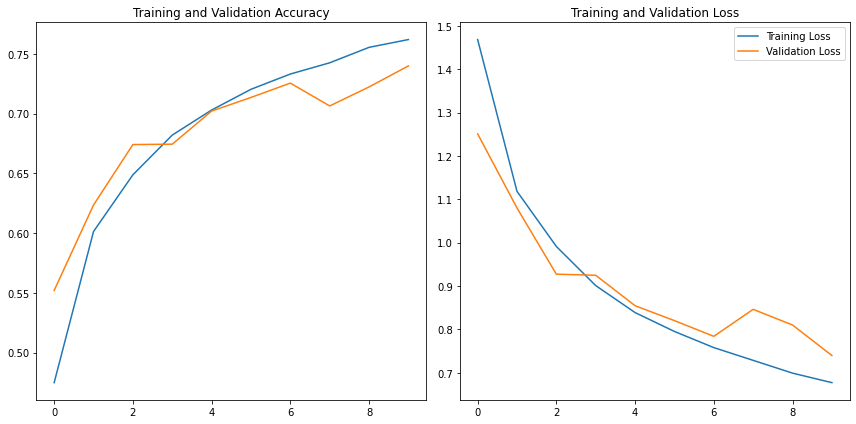

In [37]:
new_model = tf.keras.models.load_model(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

plot_results(history)

---

# Transfer Learning with ImageNet

In [38]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import absl.logging
from PIL import Image
from pathlib import Path

checkpoint_dir = Path('./checkpoints/cnn/')

absl.logging.set_verbosity(absl.logging.ERROR)

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.plot(epochs_range, acc, label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    ax2.plot(epochs_range, loss, label='Training Loss')
    ax2.plot(epochs_range, val_loss, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [39]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def formatting(image, label):
    image = tf.cast(image, tf.float32)  # cast to tf.float32
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.per_image_standardization(image)
    return image, label

def augmentation(image, label):
    image, label = formatting(image, label)
    image = tf.image.random_flip_left_right(image)  # flip
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)  # padding and crop 
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5)  # random brightness
    return image, label

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='./data/cats_vs_dogs/',
    download=True,
    with_info=True,
    as_supervised=True,
)

get_label_name = metadata.features['label'].int2str
train_batches = (raw_train.shuffle(SHUFFLE_BUFFER_SIZE).map(augmentation).batch(BATCH_SIZE))
validation_batches = (raw_validation.shuffle(SHUFFLE_BUFFER_SIZE).map(augmentation).batch(BATCH_SIZE))
test_batches = raw_test.map(formatting).batch(BATCH_SIZE)
for i in range(2):
    print(f'{i}: {get_label_name(i)}')

0: cat
1: dog


In [40]:
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,  # include the last fully-connected layer
    weights='imagenet'
)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [41]:
for image_batch, label_batch in train_batches.take(1):
    break

# feature vectors
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 512)


* [`tf.keras.layers.GlobalAveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)

In [42]:
# flatten by average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 512)


In [43]:
# create fully-connected layers
fc = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])
outputs = fc(feature_batch_average)
print(outputs.shape)

(64, 2)


In [44]:
# Freeze basemodel
base_model.trainable = False
# build model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  fc
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 sequential_3 (Sequential)   (None, 2)                 263682    
                                                                 
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
# fine tuning
EPOCHS = 5
model_name = 'catdog'
checkpoint_path = checkpoint_dir / model_name

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weight_only=False
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validation_batches, 
    callbacks=[cp_callback]
)

Epoch 1/5
291/291 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9231INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


291/291 [==============================] - 187s 640ms/step - loss: 0.2308 - accuracy: 0.9231 - val_loss: 0.1395 - val_accuracy: 0.9454
Epoch 2/5
291/291 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9517INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


291/291 [==============================] - 179s 614ms/step - loss: 0.1250 - accuracy: 0.9517 - val_loss: 0.1156 - val_accuracy: 0.9518
Epoch 3/5
291/291 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9557INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


291/291 [==============================] - 175s 602ms/step - loss: 0.1093 - accuracy: 0.9557 - val_loss: 0.1145 - val_accuracy: 0.9531
Epoch 4/5
291/291 [==============================] - 161s 553ms/step - loss: 0.1032 - accuracy: 0.9585 - val_loss: 0.1094 - val_accuracy: 0.9518
Epoch 5/5
291/291 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9598INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


INFO:tensorflow:Assets written to: checkpoints\cnn\catdog\assets


291/291 [==============================] - 176s 604ms/step - loss: 0.0994 - accuracy: 0.9598 - val_loss: 0.1043 - val_accuracy: 0.9566


10/10 [==============================] - 6s 573ms/step - loss: 0.0874 - accuracy: 0.9719
Test Loss: 0.0874, Accuracy: 0.9719


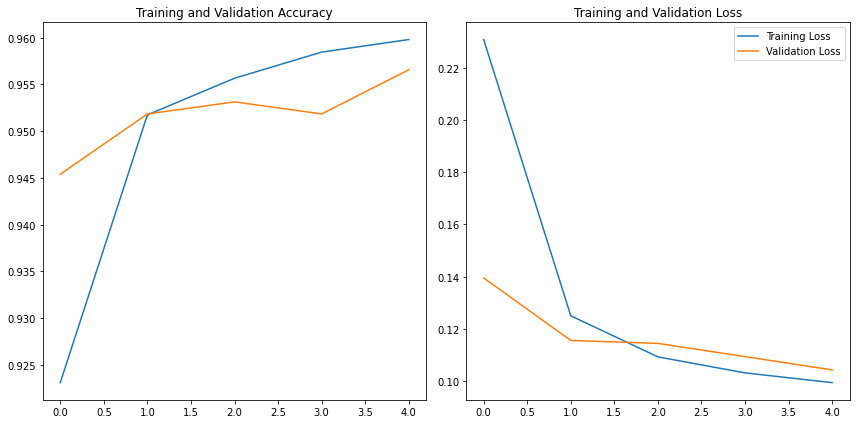

In [46]:
new_model = tf.keras.models.load_model(checkpoint_path)

loss, accuracy = new_model.evaluate(test_batches, steps=10)
print(f'Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

plot_results(history)

In [47]:
# real test from pixabay
from PIL import Image

def load_image(image_path):
    image = np.array(Image.open(image_path), dtype=np.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

cat_img = load_image('./cat_test.jpg')
dog_img = load_image('./dog_test.jpg')
labels = list(map(get_label_name, range(2)))

images = np.stack([cat_img, dog_img])  # (2, 160, 160, 3)
inputs, _ = formatting(images, None)
outputs = new_model.predict(inputs)
preds = np.argmax(outputs, axis=-1)

1/1 [==============================] - 2s 2s/step


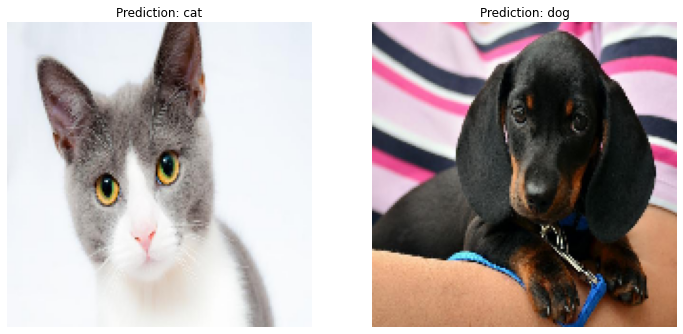

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, img, pred in zip(axes, images, preds):
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f'Prediction: {get_label_name(pred)}')
    ax.axis('off')